In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_curve, auc
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from itertools import product
from collections import OrderedDict
from sklearn import svm
%matplotlib inline

# Data Preprocessing

In [2]:
# load data. See bottom of this Notebook for the scraping code that generated this.
spotify = pd.read_csv('cs109a_final_data_Milestone3.csv')
spotify = spotify.drop(spotify.index[271]) # This is NaN
spotify = spotify.set_index(np.arange(0,len(spotify), 1))
spotify['followers'] = np.log(spotify['followers']+1)

In [3]:
# normalize variables
normalize = spotify.drop({'Unnamed: 0', 'id', 'name', 'followers', 'collab', 'user', 'genre1', 'genre2', 'genre3'}, 1).columns
for var in normalize:
    spotify[var] = (spotify[var]-spotify[var].min())/(spotify[var].max()-spotify[var].min())

In [4]:
# group spotify's 500 genre codes into a handful of genres
genres = ['rock', 'jazz', 'pop', 'rap', 'indie', 'country', 'house', 'tropical', 'christmas', 'soul', 'folk', 'classical']
for genre in genres:
    spotify[genre] = np.zeros(len(spotify))
for genre in genres:
    genreflag = np.zeros(len(spotify))
    for i in range(len(spotify)):
        if (genre in spotify['genre1'][i]) or (genre in spotify['genre2'][i]) or (genre in spotify['genre3'][i]):
            genreflag[i] = 1
    spotify[genre] = spotify[genre] + genreflag

In [5]:
# engineer genre based interactions
spotify['rocklive'] = spotify['rock']*spotify['mean_liveness']
spotify['rockloud'] = spotify['rock']*spotify['mean_loudness']
spotify['poptempo'] = spotify['pop']*spotify['mean_tempo']
spotify['jazztempo'] = spotify['jazz']*spotify['std_tempo']
spotify['rapvulgar'] = spotify['rap']*spotify['total_explicit']
spotify['classicalinstru'] = spotify['classical']*spotify['mean_instrumentalness']
spotify['popenergy'] = spotify['pop']*spotify['mean_energy']

In [6]:
# classify bottom 25% of playlists by followers "failed playlists"
cutoff = np.percentile(spotify['followers'], 25)
spotify['class'] = np.zeros(len(spotify))
for i in range(len(spotify)):
    if spotify['followers'][i] > cutoff:
        spotify.loc[i,'class'] = 1

In [7]:
# test/train split
np.random.seed(9001)
msk = np.random.rand(len(spotify)) < 0.5
data_train = spotify[msk]
data_test = spotify[~msk]
data_train = data_train.set_index(np.arange(0,len(data_train), 1))
data_test = data_test.set_index(np.arange(0, len(data_test), 1))

In [8]:
# X/Y final features
X_train = data_train.drop({'Unnamed: 0', 'id', 'name', 'followers', 'collab', 'user', 'genre1', 'genre2', 'genre3', 'class'}, 1)
Y_train = data_train['class']
X_test = data_test.drop({'Unnamed: 0', 'id', 'name', 'followers', 'collab', 'user', 'genre1', 'genre2', 'genre3', 'class'}, 1)
Y_test = data_test['class']

# Baseline Model

unregularized logistic regression with only 1 feature, max_popularity

In [9]:
logitreg = LogisticRegression(C = 1000000).fit(X_train["max_popularity"].values.reshape(-1,1),Y_train)
accuracy_score(logitreg.predict(X_test["max_popularity"].values.reshape(-1,1)), Y_test)

0.75510204081632648

This baseline model seems pretty uninformative, given we can achive about 75% accuracy by just predicting all 1's for our response.

In [10]:
fpr, tpr, thresholds=roc_curve(Y_test, logitreg.predict_proba(X_test["max_popularity"].values.reshape(-1,1))[:,1])
roc_auc = auc(fpr, tpr)
roc_auc

0.58025947929407651

Unsuprisingly, the AUC is also fairly poor for the baseline model, at 58%.

# L1 Regularized Logistic Regression

Given the size of our feature spase, we decided to use L1 regularization for the added benefit of feature selection. We also note that this performs slightly better than L2 regularization.

In [11]:
Cs = [1, 10, 100, 1000, 10000]
Cscores = []
for c in Cs:
    logitreg = LogisticRegression(C = c, penalty="l1")
    Cscores.append(np.mean(cross_val_score(logitreg, X_train, Y_train, cv=5, scoring='accuracy')))

In [12]:
bestC = Cs[np.argmax(Cscores)]
print(bestC)
print(np.max(Cscores))

1
0.795273801409


In [13]:
logitreg = LogisticRegression(C = bestC, penalty="l1").fit(X_train,Y_train)
accuracy_score(logitreg.predict(X_test), Y_test)

0.80612244897959184

In [14]:
fpr, tpr, thresholds=roc_curve(Y_test, logitreg.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
roc_auc

0.85058535733007168

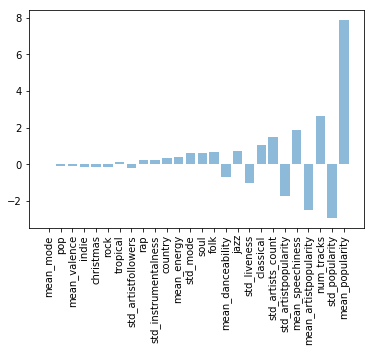

In [15]:
objects = X_train.columns
coeff = logitreg.coef_[0]
objects = objects[coeff!=0]
coeff = coeff[coeff!=0]
objects = objects[np.argsort(np.abs(coeff))]
coeff = coeff[np.argsort(np.abs(coeff))]
 
y_pos = np.arange(len(objects))
plt.bar(y_pos, coeff, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.show()

In [16]:
# features not powerful enough to be introduced given l1 regularization
print(X_train.columns[logitreg.coef_[0]==0])

Index(['mean_time', 'std_time', 'total_explicit', 'max_popularity',
       'mean_artists_count', 'mean_acousticness', 'std_acousticness',
       'std_danceability', 'std_energy', 'mean_instrumentalness',
       'mean_liveness', 'mean_loudness', 'std_loudness', 'std_speechiness',
       'mean_tempo', 'std_tempo', 'std_valence', 'mean_artistfollowers',
       'house', 'rocklive', 'rockloud', 'poptempo', 'jazztempo', 'rapvulgar',
       'classicalinstru', 'popenergy'],
      dtype='object')


In [17]:
# fraction of feature space eliminated via regularization
sum(logitreg.coef_[0]==0)/len(logitreg.coef_[0])

0.5

By utilizing regularization and cross validation, we eliminate about half our features as not influential enough to be introduced into the model, and improve our accuracy score by about 4.5%. We also improve the AUC from 58% to 85%, which is a substantial gain.

# LDA

In [18]:
lda = LinearDiscriminantAnalysis().fit(X_train, Y_train)

In [19]:
print(np.mean(cross_val_score(LinearDiscriminantAnalysis(), X_train, Y_train)))
print(LinearDiscriminantAnalysis().fit(X_train,Y_train).score(X_test, Y_test))

0.770684706847
0.799744897959


Compared to our initial Regularized Logistic Regression model, LDA fails to perform better through cross validation, leading us to believe it is a worse model. We also see it performs slightly worse on our test set.

# Random Forest

In [20]:
# Possible hyper params for Cross Validation
param_dict = OrderedDict(
    n_estimators = [100, 200, 400, 600, 800, 1000],
    max_features = [0.01, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8]
)

param_dict.values()

odict_values([[100, 200, 400, 600, 800, 1000], [0.01, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8]])

In [21]:
# cross validate
results = {}
estimators= {}
for n, f in product(*param_dict.values()):
    params = (n, f)
    est = RandomForestRegressor(oob_score=True, 
                                n_estimators=n, max_features=f, n_jobs=-1)
    est.fit(X_train, Y_train)
    results[params] = est.oob_score_
    estimators[params] = est
outparams = max(results, key = results.get)
outparams

(800, 0.8)

In [22]:
rf1 = estimators[outparams]

In [23]:
predsp = rf1.predict(X_test)
preds = np.array([1 if x >0.5 else 0 for x in  rf1.predict(X_test)])
sum(preds == Y_test)/len(Y_test)

0.8303571428571429

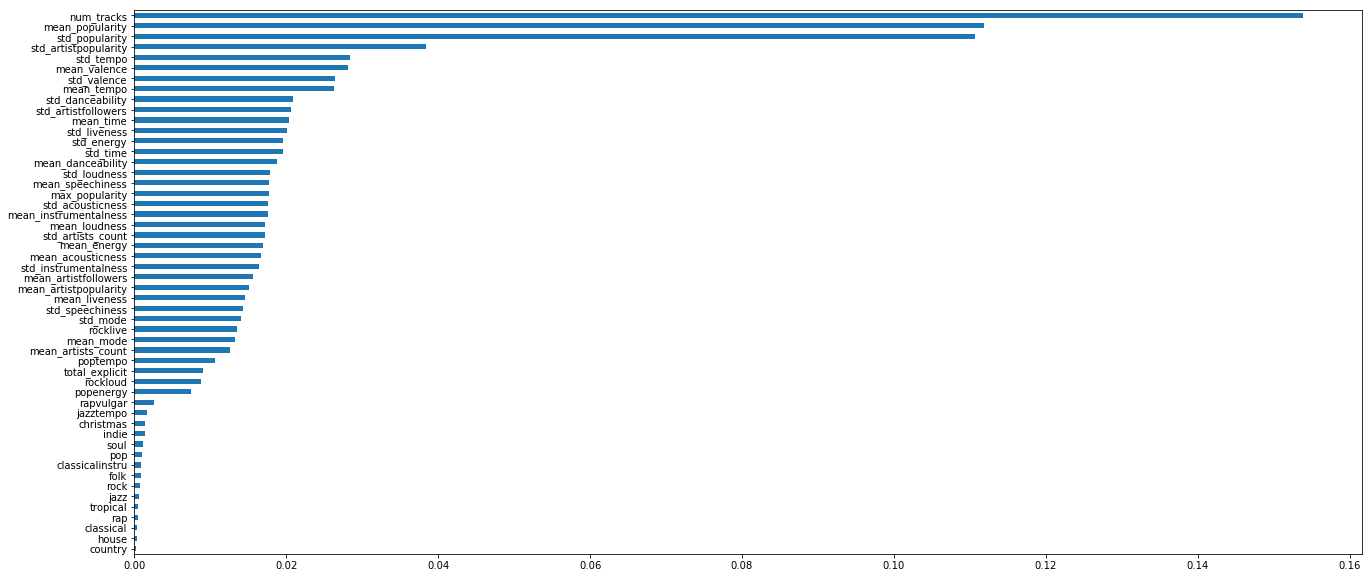

In [24]:
plt.figure(figsize=(22,10))
pd.Series(rf1.feature_importances_, index=X_train.columns).sort_values().plot(kind="barh")
plt.show()

Fitting a random forest pushes our best performance to 83% accuracy on the test set, a 3% gain above the accuracy of our regularized logistic regression's accuracy of 80%. We also notice that though somewhat different from our feature selection via l1 regularization, a portion of our feature space is of low importance.

The most influential features are somewhat similar to those that exhibit high influence on our logistic regression model. The least infleuntial features seem to be interchangably genre features or genre/audio_feature interactions.

# Support Vector Machines

In [25]:
Cs = [1, 10, 50, 100, 200, 500, 750, 1000]
cscoreL = []
cscoreP = []
cscoreRBF = []
for c in Cs:
    modelL = svm.SVC(C=c, kernel='linear')
    cscoreL.append(np.mean(cross_val_score(modelL, X_train, Y_train)))
    modelP = svm.SVC(C=c, kernel='poly')
    cscoreP.append(np.mean(cross_val_score(modelP, X_train, Y_train)))
    modelRBF = svm.SVC(C=c, kernel='rbf')
    cscoreRBF.append(np.mean(cross_val_score(modelRBF, X_train, Y_train)))

In [26]:
bestkernel = ["linear","poly",'rbf'][np.argmax([np.max(cscoreL),np.max(cscoreP),np.max(cscoreRBF)])]
bestPolyC = Cs[np.argmax(cscoreP)]
print("best kernel:" + str(bestkernel))
print("best PolyC:" + str(bestPolyC))
print("best CV score:"+ str(np.max(cscoreP)))

best kernel:poly
best PolyC:200
best CV score:0.78176392875


In [27]:
modelP = svm.SVC(C=bestPolyC, kernel=bestkernel)
modelP.fit(X_train, Y_train)
modelP.score(X_test,Y_test)

0.78188775510204078

SVMs seem to have performance akin to LDA, which is worse than our Logistic Regression and Random Forest models.

# KNN - K Nearest Neighbor

In [28]:
# cross validate for choice of K
allks = np.arange(1, ((len(X_train)*4)//5), 1)
CVScores = []
for k in allks:
    # for all possibe Ks, we fit a model with k neighbors and calculate the cross-validation score
    knnclass = KNeighborsClassifier(n_neighbors = k)
    CVScores.append(np.mean(cross_val_score(knnclass, X_train, Y_train, cv=5, scoring='accuracy')))
# we then look at the best model, which has the maximum cross-validation score
bestk = allks[CVScores.index(max(CVScores))]
print(bestk)
print(max(CVScores))

17
0.77926986291


In [29]:
knnclass = KNeighborsClassifier(n_neighbors = bestk).fit(X_train,Y_train)
accuracy_score(knnclass.predict(X_test),Y_test)

0.74234693877551017

This is rather dissapointing performance, given we could do better by predicting all 1's (since our binary response by construction is 25% 0's and 75% 1's). This poor performance is likely attributatble to the neighbors being matched along uninformative dimensions. Let's try to improve this by utilizing some of the feature importance scores from our Random Forest model.

In [30]:
# cross validate for choice of K
allks = np.arange(1, ((len(X_train)*4)//5), 1)
allks = allks[0:30]
params = []
CVScores = []

for n in range(1,10):
    # pluck off top n important features from Random Forest
    rf_mostimport = pd.Series(rf1.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    rf_mostimport = list(rf_mostimport.head(n).items())
    rf_mostimport = zip(*rf_mostimport)
    rf_mostimport = list(list(rf_mostimport)[0])
    for k in allks:
        # for all possibe Ks, we fit a model with k neighbors and calculate the cross-validation score
        knnclass = KNeighborsClassifier(n_neighbors = k)
        CVScores.append(np.mean(cross_val_score(knnclass, X_train[rf_mostimport], Y_train, cv=5, scoring='accuracy')))
        params.append((n, k))
# we then look at the best model, which has the maximum cross-validation score
bestparams = params[CVScores.index(max(CVScores))]
print("The best (n, k) pair is" + str(bestparams))
print("With a CV score of" + str(max(CVScores)))

The best (n, k) pair is(9, 30)
With a CV score of0.822419147164


In [31]:
bestn = bestparams[0]
bestk = bestparams[1]

# pluck off top n important features from Random Forest
rf_mostimport = pd.Series(rf1.feature_importances_, index=X_train.columns).sort_values(ascending=False)
rf_mostimport = list(rf_mostimport.head(bestn).items())
rf_mostimport = zip(*rf_mostimport)
rf_mostimport = list(list(rf_mostimport)[0])
                     
knnclass = KNeighborsClassifier(n_neighbors = bestk).fit(X_train[rf_mostimport],Y_train)
accuracy_score(knnclass.predict(X_test[rf_mostimport]),Y_test)

0.81377551020408168

We see we are able to improve the performance of the KNN model from 0.74 fit across our entire feature space to 0.81 fit over a more influential subspace. This makes sense given the underlying KNN algorithm, where datapoints can be near neighbors along useless dimensions, squashing out the influence of thier proximity to points along useful dimensions.

# Stacked Models
In an attempt to squeeze additional predictive power out of our models, we stacked them into a Random Forest meta model, and then evaluated its performance on a left-out fraction of the test data.

In [32]:
from sklearn.model_selection import KFold

In [33]:
modelsprob = [lda, logitreg, knnclass]
models = [rf1, modelP]
kf = KFold(n_splits = 10)
metaclass = pd.DataFrame()
for model in models:
    metaclass[model] = np.zeros(len(X_train))
    for train_index, test_index in kf.split(X_train):
        y_train, y_test = Y_train[train_index], Y_train[test_index]
        x_train, x_test = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
        model.fit(x_train, y_train)
        metaclass[model][test_index] = model.predict(x_test)
for model in modelsprob:
    metaclass[model] = np.zeros(len(X_train))
    for train_index, test_index in kf.split(X_train):
        y_train, y_test = Y_train[train_index], Y_train[test_index]
        x_train, x_test = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
        model.fit(x_train, y_train)
        metaclass[model][test_index] = list(zip(*model.predict_proba(x_test)))[1]

In [34]:
metaclass_test = pd.DataFrame()
for model in models:
    model.fit(X_train, Y_train)
    metaclass_test[model] = model.predict(X_test)
for model in modelsprob:
    model.fit(X_train, Y_train)
    metaclass_test[model] = list(zip(*model.predict_proba(X_test)))[1]

In [35]:
metaclass.columns = ['Random Forest', 'SVM Poly', 'LDA', 'Logistic', 'KNN']

In [36]:
# Possible hyper params for Cross Validation
param_dict = OrderedDict(
    n_estimators = [100, 200, 400, 600, 800, 1000],
    max_features = [0.01, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8]
)

param_dict.values()

odict_values([[100, 200, 400, 600, 800, 1000], [0.01, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8]])

In [37]:
# cross validate
results = {}
estimators= {}
for n, f in product(*param_dict.values()):
    params = (n, f)
    est = RandomForestRegressor(oob_score=True, 
                                n_estimators=n, max_features=f, n_jobs=-1)
    est.fit(metaclass, Y_train)
    results[params] = est.oob_score_
    estimators[params] = est
outparams = max(results, key = results.get)
outparams

(800, 0.01)

In [38]:
rf2 = estimators[outparams]
predsp = rf2.predict(metaclass_test)
preds = np.array([1 if x >0.5 else 0 for x in predsp])
sum(preds == Y_test)/len(Y_test)

0.80739795918367352

We see that our stacked model is comparable to the test performance of our best component model to the stack, but it was worth a shot. Analyzing the importance of the of the compoenent models shows that our best models of RF and Logit are most infleuntial, but in the ensemble that LDA actually has something more to add relative to solo performance.

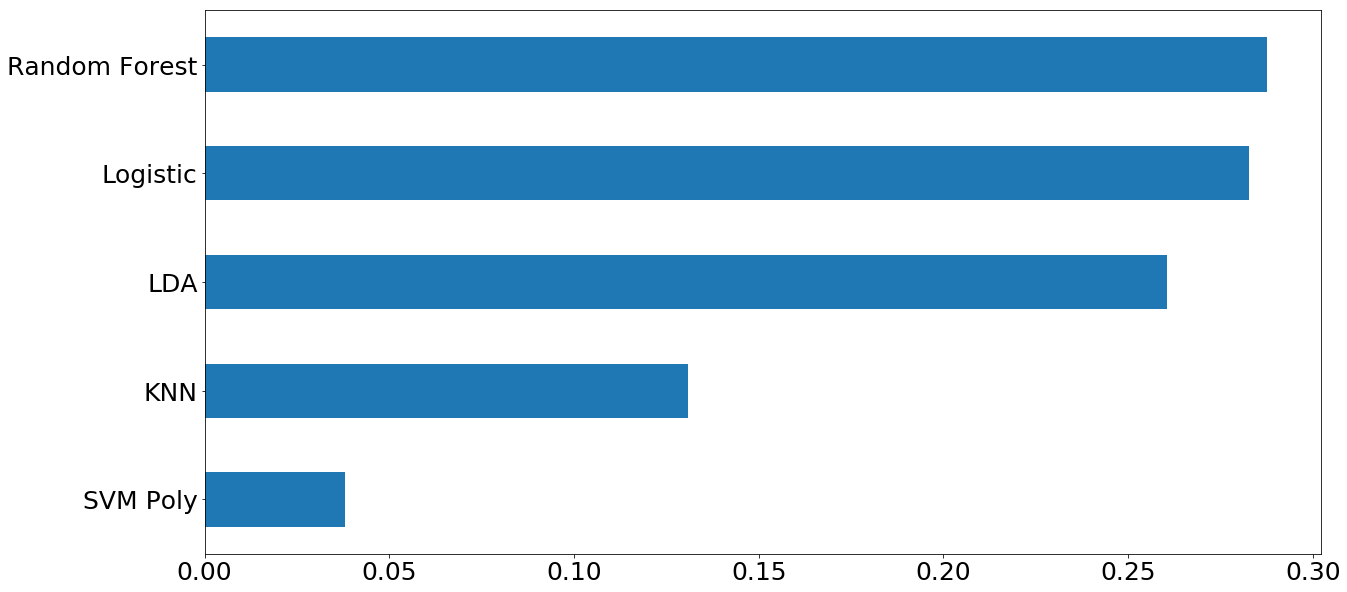

In [39]:
plt.figure(figsize=(20,10))
pd.Series(rf2.feature_importances_, index=metaclass.columns).sort_values().plot(kind="barh")
plt.tick_params(axis='both', which='major', labelsize=25)
plt.show()

# Scraper Code

This is the code we used to scape the data from the API. We wrapped it in a function to prevent it executing. Given that some API requests are rejected, we ran it over several times, replacing useridpairs with the failedpairs to avoid making redundant requests.

In [40]:
import spotipy
from spotipy import util
import pandas as pd
import numpy as np
import ssl
import OpenSSL
from collections import Counter

In [41]:
# This takes all night to run. I advise against executing it.
def scraper():
    token = util.prompt_for_user_token("spects4@gmail.com",   #username,
                           "playlist-read-private",#scope,
                           client_id='b9e26d8ba491478fb328b53dc7390b0d',
                           client_secret='1bf51eeb645f49f4a8e5b5dd2b086585',
                           redirect_uri='http://localhost:8888/notebooks/')
    sp = spotipy.Spotify(auth=token)
    
    playlists = sp.user_playlists("Spotify")
    playlistsIDs = []
    while playlists:
        for i, playlist in enumerate(playlists['items']):
            playlistsIDs.append(playlist["uri"])
        if playlists['next']:
            playlists = sp.next(playlists)
        else:
            playlists = None
    
    useridpairs = []
    for pid in playlistsIDs:
        l = pid.split(":")
        useridpairs.append((l[2],l[4]))
    
    features = []
    failedpairs = []
    for playlistsID in useridpairs:
        try:
            print(playlistsID)
            pl = sp.user_playlist(playlistsID[0], playlistsID[1])
            pltracks = pl["tracks"]["items"]
            durations = []
            explicits = []
            populars = []
            artistsnum = []
            acousticness = []
            danceability = []
            energy = []
            instrumentalness = []
            liveness = []
            loudness = []
            mode =[]
            speechiness=[]
            tempo=[]
            valence=[]
            genres = []
            artistfollowers = []
            artistpopularity = []
            for track in pltracks:

                track = track["track"]
                durations.append(track["duration_ms"])
                explicits.append(track["explicit"])
                populars.append(track["popularity"])
                artistsnum.append(len(track["artists"]))
                audiofeats = sp.audio_features(track["uri"])[0]
                if audiofeats != None:
                    acousticness.append(audiofeats["acousticness"])
                    danceability.append(audiofeats["danceability"])
                    energy.append(audiofeats["energy"])
                    instrumentalness.append(audiofeats["instrumentalness"])
                    liveness.append(audiofeats["liveness"])
                    loudness.append(audiofeats["loudness"])
                    mode.append(audiofeats["mode"])
                    speechiness.append(audiofeats["speechiness"])
                    tempo.append(audiofeats["tempo"])
                    valence.append(audiofeats["valence"])
                arts = sp.artist(track["artists"][0]["uri"])
                if arts["genres"] != None:
                    genres = genres + list(arts["genres"])
                else:
                    genres = genres + [None]
                artistfollowers.append(arts["followers"]["total"])
                artistpopularity.append(arts["popularity"])


            genrecount = Counter(genres)
            mc_genre = genrecount.most_common(3)
            g1 = mc_genre[0][0]
            g2 = mc_genre[1][0]
            g3 = mc_genre[2][0]
            features.append([playlistsID[1],
                             pl["name"],
                             pl["followers"]["total"],
                             pl["collaborative"],
                            len(pltracks),
                            np.mean(durations),
                            np.std(durations),
                            sum(explicits),
                            np.mean(populars),
                            np.std(populars),
                            np.max(populars),
                            np.mean(artistsnum),
                            np.std(artistsnum),
                           playlistsID[0],

                             np.mean(acousticness),
                            np.std(acousticness),
                             np.mean(danceability),
                            np.std(danceability),
                             np.mean(energy),
                            np.std(energy),
                             np.mean(instrumentalness),
                            np.std(instrumentalness),
                             np.mean(liveness),
                            np.std(liveness),
                             np.mean(loudness),
                            np.std(loudness),
                             np.mean(mode),
                            np.std(mode),
                             np.mean(speechiness),
                            np.std(speechiness),
                             np.mean(tempo),
                            np.std(tempo),
                             np.mean(valence),
                            np.std(valence),

                             np.mean(artistfollowers),
                            np.std(artistfollowers),
                            np.mean(artistpopularity),
                            np.std(artistpopularity),
                             g1,
                             g2,
                             g3
                            ])

        except spotipy.client.SpotifyException as x:
            print(playlistsID)
            failedpairs.append(playlistsID)
            print(x)
            if x.http_status == 401:
                token = util.prompt_for_user_token("spects4@gmail.com",   #username,
                               "playlist-read-private",#scope,
                               client_id='b9e26d8ba491478fb328b53dc7390b0d',
                               client_secret='1bf51eeb645f49f4a8e5b5dd2b086585',
                               redirect_uri='http://localhost:8888/notebooks/')
                sp = spotipy.Spotify(auth=token)
        except Exception as x:
            failedpairs.append(playlistsID)
            print(x)
            print(playlistsID)
        
    df = pd.DataFrame(features, columns = ["id",
                                      "name",
                                      "followers",
                                      "collab",
                                      "num_tracks",
                                      "mean_time",
                                      "std_time",
                                     "total_explicit",
                                     "mean_popularity",
                                     "std_popularity",
                                     "max_popularity",
                                     "mean_artists_count",
                                     "std_artists_count",
                                     "user",
                                     "mean_acousticness",
                                    "std_acousticness",
                                    "mean_danceability",
                                    "std_danceability",
                                    "mean_energy",
                                    "std_energy",
                                    "mean_instrumentalness",
                                    "std_instrumentalness",
                                           "mean_liveness",
                                    "std_liveness",
                                           "mean_loudness",
                                    "std_loudness",
                                           "mean_mode",
                                    "std_mode",
                                           "mean_speechiness",
                                    "std_speechiness",
                                           "mean_tempo",
                                    "std_tempo",
                                           "mean_valence",
                                    "std_valence",
                                           "mean_artistfollowers",
                                    "std_artistfollowers",
                                           "mean_artistpopularity",
                                    "std_artistpopularity",
                                          "genre1",
                                           "genre2",
                                           "genre3"
                                        ])